## My Convolution Implementation

For a discrete time signal $x[n]$ with a discrete time filter $h[n]$, the convolution between the two is defined as follows:

\begin{equation}
    (x \ast h)[n] = \sum_{k = - \infty}^{ \infty} x[k] h[n-k]
\end{equation}


Since neither our signal or the filter are infinite in time, this sum is over a finite number of values.

If we were to do this as defined, we would end up with a resulting signal of length:

$\mathrm{len}(x[n]) + \mathrm{len}(y[n]) - 1$. 

Therefore, we also need to make sure we truncate our output such that it is the same length as the max of the lengths of the filter or signal. Based on the desired length, we can center slice/crop the resulting vector to get the desired output length.

### Load filter and impulse response

We start by loading the filter.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

h = np.array([-0.01452123, -0.0155227 ,  0.01667252,  0.01800633, -0.01957209, -0.0214361 ,  0.02369253,  0.02647989, -0.03001054, -0.03462755, 0.04092347,  0.05001757, -0.06430831, -0.09003163,  0.15005272, 0.45015816,  0.45015816,  0.15005272, -0.09003163, -0.06430831, 0.05001757,  0.04092347, -0.03462755, -0.03001054,  0.02647989, 0.02369253, -0.0214361 , -0.01957209,  0.01800633,  0.01667252, -0.0155227 , -0.01452123])

Text(0.5, 1.0, 'Impulse Response of Kaiser Filter')

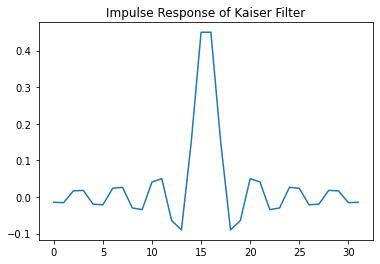

In [2]:
plt.plot(h)
plt.title('Impulse Response of Kaiser Filter')

#### Write convolution function

The convolution operation involves flipping one of the signals and computing an overlapping sum as a sliding window over the other signal. We implement this in python as follows.

In [3]:
def convolution(x, h):
    # find flipped version of h
    h_flipped = h[::-1].copy()
    
    # Result size before cropping
    result_size = len(x) + len(h) - 1
    convolution_result = np.empty(result_size)
    
    # pad signal with zeros at the beginning and end with (h.size - 1) zeros
    signal = np.pad(x, len(h) - 1)
    
    # write a loop to find dot product of sliding window of flipped filter with the signal for convolution operation 
    for ind in range(result_size):
        convolution_result[ind] = np.dot(signal[ind:ind+len(h)], h_flipped)
    
    # Now we need to slice the middle elements of this result of length max(x.size, h.size)
    desired_length = np.max([len(x), len(h)])
    
    start = len(convolution_result) // 2 - desired_length // 2
    stop = len(convolution_result) // 2 + desired_length // 2
    
    final_result = convolution_result[start:stop+1]
    
    final_result = final_result[:desired_length]
    
    return final_result


This method of looping and computing dot products of the filter with a padded version of the signal is going to be much slower than the numerical optimizations that numpy offers, likely using FFT to do convolution in the frequency domain and other optimizations.

#### Compare result with `np.convolve()` output using the 5 Hz sawtooth wave like before

In [4]:
from scipy.signal import sawtooth

t = np.linspace(0, 1, 500)

sawtooth_wave = 10 * sawtooth(2 * np.pi * 5 * t, width=0.9)
noisy_wave = sawtooth_wave + np.random.normal(size=sawtooth_wave.shape)

# Convolve filter with wave, first with my loop function
my_convolution = convolution(h, noisy_wave)

print('First 10 values of my solution:\n', my_convolution[:10])

np_convolution = np.convolve(h, noisy_wave, mode='same')

print('\nFirst 10 values of Numpy solution:\n', np_convolution[:10])

First 10 values of my solution:
 [ -4.63258884  -9.06384781 -10.52205631  -9.53908666  -8.85362936
  -9.48309039 -10.03233952  -9.36378989  -8.16964289  -7.64837478]

First 10 values of Numpy solution:
 [ -4.63258884  -9.06384781 -10.52205631  -9.53908666  -8.85362936
  -9.48309039 -10.03233952  -9.36378989  -8.16964289  -7.64837478]


The `convolution()` function appears to get the correct result. Just to be sure, we can plot both.

Text(0.02, 0.5, 'Signal Amplitude')

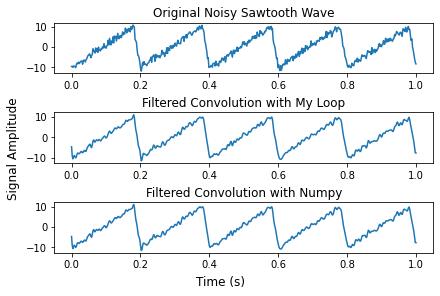

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True)

ax1.plot(t, noisy_wave)
ax2.plot(t, my_convolution)
ax3.plot(t, np_convolution)

ax1.set_title('Original Noisy Sawtooth Wave')
ax2.set_title('Filtered Convolution with My Loop')
ax3.set_title('Filtered Convolution with Numpy')

fig.supxlabel('Time (s)')
fig.supylabel('Signal Amplitude')

Function works as expected, but is very likely less optimal than the standard numpy implementation.